In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pydicom

%matplotlib inline

In [2]:
os.chdir('C:\\Users\\steve\\OneDrive\\Data Science MSc\\MSc Project') # get to the right directory

##### Exploring the Data

In [3]:
# import data and show head
df = pd.read_csv('THIS_IS_IT.csv')
df.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,377981,4139,Control,M,81,1,MRI,Axial PD-T2 TSE FS,Original,04/09/2013,DCM,NaN
1,436432,4136,PD,M,57,5,MRI,Axial PD-T2 TSE FS,Original,05/06/2014,DCM,NaN
2,377973,4136,PD,M,56,1,MRI,Axial PD-T2 TSE FS,Original,2/28/2013,DCM,NaN
3,377952,4135,PD,M,67,1,MRI,Axial PD-T2 TSE FS,Original,03/01/2013,DCM,NaN
4,377945,4085,Control,M,67,1,MRI,Axial PD-T2 TSE FS,Original,04/08/2013,DCM,NaN


In [4]:
descriptions_array = df.Description.values
np.unique(descriptions_array, return_counts=True) 

(array(['AXIAL PD-T2 TSE FS', 'Axial PD-T2 TSE', 'Axial PD-T2 TSE FS',
        'Axial PD-T2 TSE_AC PC line', 'Axial PD-T2 TSE_AC/PC line',
        'Axial PD-T2-FS TSE', 'T2'], dtype=object),
 array([ 33, 292, 356,   2,  24,  23,   1], dtype=int64))

So we can see that the majority is Axial PD-T2 TSE and Axial PD-T2 TSE FS, leaving us with 292 or 356. 

In [5]:
# looks like a bunch of Axial PD-T2 TSE are mislabelled or slightly different, change these
dscrptn = df['Description'].replace({'Axial PD-T2-FS TSE':'Axial PD-T2 TSE FS', 'AXIAL PD-T2 TSE FS':'Axial PD-T2 TSE FS', 
                           'Axial PD-T2 TSE_AC PC line':'Axial PD-T2 TSE_AC/PC line'})

df['Description'] = dscrptn

In [6]:
np.unique(df.Description.values, return_counts=True) 

(array(['Axial PD-T2 TSE', 'Axial PD-T2 TSE FS',
        'Axial PD-T2 TSE_AC/PC line', 'T2'], dtype=object),
 array([292, 412,  26,   1], dtype=int64))

Looks about right, decide to go with TSE FS as this has more data. Looks like many patients had both scans.

In [7]:
df2 = df[df['Description']=='Axial PD-T2 TSE FS']
print (len(df2))
df2.head()

412


,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,377981,4139,Control,M,81,1,MRI,Axial PD-T2 TSE FS,Original,04/09/2013,DCM,NaN
1,436432,4136,PD,M,57,5,MRI,Axial PD-T2 TSE FS,Original,05/06/2014,DCM,NaN
2,377973,4136,PD,M,56,1,MRI,Axial PD-T2 TSE FS,Original,2/28/2013,DCM,NaN
3,377952,4135,PD,M,67,1,MRI,Axial PD-T2 TSE FS,Original,03/01/2013,DCM,NaN
4,377945,4085,Control,M,67,1,MRI,Axial PD-T2 TSE FS,Original,04/08/2013,DCM,NaN


In [8]:
# Change the object type to dates for date
df2['Acq Date'] = pd.to_datetime(df2['Acq Date'], format='%d/%M/%Y')

C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
df2.info() # just get understanding of types of data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412 entries, 0 to 729
Data columns (total 12 columns):
Image Data ID    412 non-null int64
Subject          412 non-null int64
Group            412 non-null object
Sex              412 non-null object
Age              412 non-null int64
Visit            412 non-null int64
Modality         412 non-null object
Description      412 non-null object
Type             412 non-null object
Acq Date         412 non-null datetime64[ns]
Format           412 non-null object
Downloaded       0 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(6)
memory usage: 41.8+ KB


In [10]:
# count number with PD and number of controls
np.unique(df2.Group, return_counts=True)

(array(['Control', 'PD'], dtype=object), array([ 50, 362], dtype=int64))

In [11]:
# So keep only one scan per patient and use the most recent scans
df3 = df2.sort_values('Acq Date').drop_duplicates('Subject',keep='last')

In [12]:
# count number with PD and number of controls
np.unique(df3.Group, return_counts=True)

(array(['Control', 'PD'], dtype=object), array([ 36, 154], dtype=int64))

We can see that some patients have multiple scans and different dates. Treat these as independent occurances. 
<br>
Plan:
-  Get all subject ID's
-  Search these folders, if more than 1 subfolder, take the second which will be the TSE FS files
-  Then each scan subfolder is treated as an independent case (important to mention) as we have 412 patients but 729 scans i.e. some patients had more than one scan over time. Balance this out by just selecting one image per patient
    -  By one image per patient, it is meant that the last image is selected for classification, so we should have 412 images overall, balancing out the ratio slightly. Select the last one
    -  Problem with selecting the last one however is that it is the latest scan (most recent one), meaning it is more likely to be later stage PD in development. Meaning we may have a harder time diagnosing those with early stages of PD
    -  Way to go around this would be to train with the earliest stage of a classifier or use another MRI data source set

In [13]:
# establish control and pd df's
df_control = df2[df2.Group == 'Control'] # for control, keep duplicate subject n.o's
df_pd = df3[df3.Group == 'PD'] 

In [14]:
print ("Number of control patients: %d " % len(df_control))
print ("Number of PD patients: %d " % len(df_pd))

Number of control patients: 50 
Number of PD patients: 154 


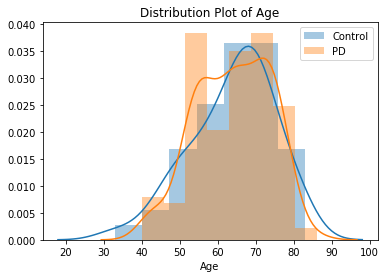

In [15]:
# seaborn distribution plot
sns.distplot(df_control.Age, rug=False, label='Control')
sns.distplot(df_pd.Age, rug=False, label='PD')
plt.title('Distribution Plot of Age')
plt.legend()
plt.show()

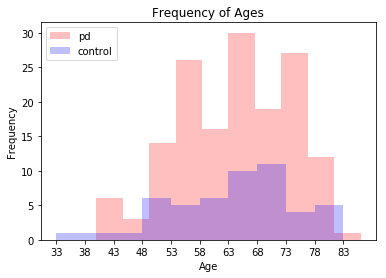

In [16]:
# plot for the ages
plt.hist(df_pd.Age, align='mid', alpha=0.25, color='r', label='pd', bins=10)
plt.hist(df_control.Age, align='mid', alpha=0.25, color='b', label='control', bins=10)
plt.legend(loc='upper left')

# set labels
plt.ylabel('Frequency')
plt.xlabel('Age')
plt.title('Frequency of Ages')

# set ticks
plt.xticks(np.arange(min(df_control.Age), max(df_control.Age)+1, 5.0))
plt.show()

What can happen if we have too many PD compared to control? Without balancing (by only allowing one scan per patient, we reduce the ratio from 7:1 between PD to Control to about 1:5. If we just do this method for PD patients only, we can set the ratio to about 1:3 (which is what we will go with) so we have a balanced set to train as possible. Though it means we only have 204 instances to train with.

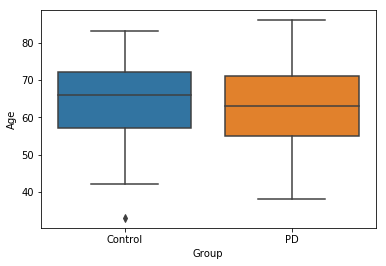

In [17]:
# some boxplots
ax = sns.boxplot(x="Group", y="Age", data=df2)

For each, control and PD we can state the number of M and F in each.

In [18]:
print ("For Control:")
print (np.unique(df_control.Sex.values, return_counts=True))
print ("For PD")
print (np.unique(df_pd.Sex.values, return_counts=True))

For Control:
(array(['F', 'M'], dtype=object), array([10, 40], dtype=int64))
For PD
(array(['F', 'M'], dtype=object), array([ 53, 101], dtype=int64))


##### Find the right subjects and image scan ID's and search files for these, build a list of directories to scan
Then build a corresponding datastructure.
-  Datastructure: Dictionary {Image_ID: List of DCM Files}

In [19]:
# Logic:
# First compile both control and PD into some super DF
# Then make a list of all the corresponding subject ID's
# Then make a list of all the corresponding Image ID's

# Loop through to get the right folders (one that match with subject ID)
# open the last subfolder (MRI TSE) *So using [-1] slicing*
# open the last subfolder again ( most recent dated image )
# 's' + image_id is the subfolder to store
# store the path

# Then Store the list of DCM files 

In [20]:
df_u = pd.concat([df_control, df_pd]) # df ultima
df_u = df_u.sample(frac=1) # randomly shuffle df
df_u.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
80,665292,4019,PD,F,59,11,MRI,Axial PD-T2 TSE FS,Original,2016-01-01 00:27:00,DCM,NaN
260,382353,3779,Control,M,57,5,MRI,Axial PD-T2 TSE FS,Original,2013-01-06 00:26:00,DCM,NaN
572,901146,3190,PD,M,86,11,MRI,Axial PD-T2 TSE FS,Original,2017-01-05 00:04:00,DCM,NaN
612,430154,3173,PD,F,64,7,MRI,Axial PD-T2 TSE FS,Original,2014-01-03 00:19:00,DCM,NaN
409,548983,3551,Control,M,69,90,MRI,Axial PD-T2 TSE FS,Original,2015-01-10 00:22:00,DCM,NaN


In [21]:
u_subject_id = df_u.Subject.values # gets the required ID's
u_subject_id

array([4019, 3779, 3190, 3173, 3551, 3823, 3826, 3102, 4012, 3787, 3323,
       3309, 4025, 3328, 3577, 3776, 4022, 3131, 3351, 3589, 3387, 3557,
       3372, 4139, 4038, 3835, 3757, 4136, 4082, 3368, 3592, 3361, 4085,
       4027, 3857, 3815, 3314, 3377, 3867, 3552, 3832, 3132, 3367, 3819,
       3788, 4032, 3859, 4033, 3866, 3763, 3359, 3182, 3185, 3310, 3588,
       4067, 3221, 3365, 3106, 3559, 3800, 3563, 3174, 3808, 3375, 4085,
       3575, 3390, 3778, 3127, 3829, 3563, 3383, 4081, 3321, 3124, 3105,
       3852, 3585, 3308, 3122, 3824, 3584, 4024, 3386, 3389, 3830, 3118,
       3128, 3123, 3392, 3869, 4032, 3307, 3389, 3154, 3789, 3119, 3834,
       3554, 3863, 4135, 3120, 3130, 3301, 3106, 3107, 3558, 3113, 3853,
       3373, 3175, 3184, 3380, 4037, 4069, 4020, 3378, 3591, 3371, 3771,
       3777, 3325, 3752, 3353, 3822, 4035, 3854, 3556, 3853, 3870, 4085,
       3762, 3567, 3587, 3564, 3775, 3838, 3868, 3116, 3760, 3301, 3855,
       4011, 3851, 4026, 3374, 3191, 4083, 3318, 33

In [52]:
path = 'C:\\Users\\steve\\Downloads\\PPMI_THIS_IS_IT'
os.chdir(path) # move to the right dir

In [53]:
print ("Current Path: '%s' " % os.getcwd())

Current Path: 'C:\Users\steve\Downloads\PPMI_THIS_IS_IT' 


In [54]:
# vertical then horizontal, go into first subject id
path_p1 = (path + '\\' + str(u_subject_id[0]))
path_p2 = (path_p1 + '\\' + os.listdir(path_p1)[-1]) # get fs
path_p3 = (path_p2 + '\\' + os.listdir(path_p2)[-1]) # get most recent scan
path_p4 = (path_p3 + '\\' + os.listdir(path_p3)[-1]) # p_4 has all the dcm files

os.listdir(path_p4)[:5] # the part beginning 'I482301' is the part which is the image ID

['PPMI_4019_MR_AXIAL_PD-T2_TSE_FS_br_raw_20160427130925954_90_S405069_I665292.dcm',
 'PPMI_4019_MR_AXIAL_PD-T2_TSE_FS_br_raw_20160427130926043_102_S405069_I665292.dcm',
 'PPMI_4019_MR_AXIAL_PD-T2_TSE_FS_br_raw_20160427130928231_104_S405069_I665292.dcm',
 'PPMI_4019_MR_AXIAL_PD-T2_TSE_FS_br_raw_20160427130929739_63_S405069_I665292.dcm',
 'PPMI_4019_MR_AXIAL_PD-T2_TSE_FS_br_raw_20160427130931969_88_S405069_I665292.dcm']

In [55]:
print (path_p4)

C:\Users\steve\Downloads\PPMI_THIS_IS_IT\4019\Axial_PD-T2_TSE_FS\2016-01-27_13_08_24.0\S405069


In [56]:
dcm_files_test = os.listdir(path_p4) # get an individual dcom file

In [57]:
os.chdir(path_p4) # change the working dir to path p4
os.getcwd()

'C:\\Users\\steve\\Downloads\\PPMI_THIS_IS_IT\\4019\\Axial_PD-T2_TSE_FS\\2016-01-27_13_08_24.0\\S405069'

In [58]:
length_of_dcm = (len(dcm_files_test)) # get range length
print (length_of_dcm)

54


In [59]:
dcm_files_test[0]

'PPMI_4019_MR_AXIAL_PD-T2_TSE_FS_br_raw_20160427130925954_90_S405069_I665292.dcm'

In [60]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [61]:
# make it a function for a widget
def f(i):
    slices = pydicom.read_file(dcm_files_test[i]) # uh oh, it is not ordered
    plt.imshow(slices.pixel_array)
    plt.show()
    return None

In [62]:
interact(f, i=14) # now we have a slidebar, woo! Covers all data values

interactive(children=(IntSlider(value=14, description='i', max=42, min=-14), Output()), _dom_classes=('widget-…

<function __main__.f(i)>

Problem: Need to order the slices properly

In [63]:
def filename_sort(filename):
    int_return = None # what to return 
    
    if (len(filename) == 79):
        int_return = int(filename[57:59]) # if 2 characters
    if (len(filename) == 80):
        int_return = int(filename[57:60]) # if 3 characters
    if (len(filename) == 78):
        int_return = int(filename[57]) # if 1 character
        
    return int_return

Note: The 3 characer approach might not work for 1 character

In [64]:
sorted_slices = sorted(dcm_files_test, key=lambda filename: filename_sort(filename)) # some have length 3
sorted_slices[:5] # perfect

['PPMI_4019_MR_AXIAL_PD-T2_TSE_FS_br_raw_20160427131014748_55_S405069_I665292.dcm',
 'PPMI_4019_MR_AXIAL_PD-T2_TSE_FS_br_raw_20160427131123369_56_S405069_I665292.dcm',
 'PPMI_4019_MR_AXIAL_PD-T2_TSE_FS_br_raw_20160427131134975_57_S405069_I665292.dcm',
 'PPMI_4019_MR_AXIAL_PD-T2_TSE_FS_br_raw_20160427131128457_58_S405069_I665292.dcm',
 'PPMI_4019_MR_AXIAL_PD-T2_TSE_FS_br_raw_20160427131116273_59_S405069_I665292.dcm']

In [65]:
# make it a function for a widget
def f(i):
    slices = pydicom.read_file(sorted_slices[i]) # uh oh, it is not ordered
    plt.imshow(slices.pixel_array)
    plt.show()
    return None

In [66]:
interact(f, i=widgets.IntSlider(min=0,max=(len(sorted_slices)-1),step=1,value=0)) # now we have a sorted slidebar!, wooooo! Covers all data values

interactive(children=(IntSlider(value=0, description='i', max=53), Output()), _dom_classes=('widget-interact',…

<function __main__.f(i)>

In [67]:
# turn the slices array into a matrix for input into our deep learning model
pixel_arrays = [(pydicom.read_file(s)).pixel_array for s in sorted_slices]
pixel_arrays = np.array(pixel_arrays)

print ("3D Pixel Arrays: %s" % (np.shape(pixel_arrays),))

3D Pixel Arrays: (54, 256, 232)


The above is then an example of obtaining one pixel array for one set of scans, we will then attach that to a key which has image_id. This will allow us to cross reference this to whether the patient has PD or not.

##### Now try to skull strip and segment the brain tissue, we can use the example of pixel_arrays

In [68]:
import nibabel as nb # write/process to some common neuroimaging file formats
from deepbrain import Extractor # Trying now, installing a bunch of packages..

Found the problem space, will try to see if this works with deepbrain. Seems like problem is converting the image type

Made test file with nii file (after conversion with dicom2nifti #https://github.com/icometrix/dicom2nifti then using that and converting it. Then made another folder and dumped the files in there. (Perhaps should dump all into one common folder though. Also there is a good possibility that we lose the order of our images. So may need to re-order these in the file after sorting. Or apply the mask THEN re-order the files!

File 4019 as a test, that is our folder. Make a mask out of that one.
Requires:
switch dir
open make folder to nii type (and put in another folder)
go into new folder and unzip
load nifti image as 3d image
extract it
probability mask
apply

In [69]:
os.getcwd()

'C:\\Users\\steve\\Downloads\\PPMI_THIS_IS_IT\\4019\\Axial_PD-T2_TSE_FS\\2016-01-27_13_08_24.0\\S405069'

In [73]:
import dicom2nifti

# Converting a directory with dicom files to nifti files
dicom_directory = os.getcwd()
output_folder = os.getcwd()[:-7] # put file in the folder superseding the most recent
dicom2nifti.convert_directory(dicom_directory, output_folder, compression=True, reorient=True)

In [78]:
os.chdir(output_folder)
os.listdir()

['11_axial_pd-t2_tse_fs.nii.gz', 'S405069']

In [84]:
os.listdir()

['11_axial_pd-t2_tse_fs.nii.gz', 'S405069']

In [85]:
newdir = os.getcwd() + '\\' +os.listdir()[0]

In [86]:
# Load a nifti as 3d numpy image [H, W, D]
img = nb.load(newdir).get_fdata() # loads it even as a gz file

ext = Extractor()

# `prob` will be a 3d numpy image containing probability 
# of being brain tissue for each of the voxels in `img`
prob = ext.run(img) 

# mask can be obtained as:
mask = prob > 0 # may have to adjust this value

In [87]:
np.shape(pixel_arrays)

(54, 256, 232)

In [88]:
np.shape(mask)

(232, 256, 54)

In [89]:
np.shape(pixel_arrays.T)

(232, 256, 54)

In [91]:
pa = pixel_arrays.T.copy()

In [93]:
pa[mask] == 0

array([False, False, False, ..., False, False, False])

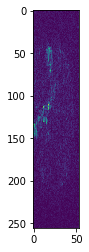

In [106]:
plt.imshow(pa[20]) # plot the original
plt.show()

In [51]:
pa[0][reshaped_mask_n[19]] = 0 # can do one index at a time

IndexError: boolean index did not match indexed array along dimension 1; dimension is 232 but corresponding boolean dimension is 228

In [ ]:
plt.imshow(pa[0]) # applied mask works.. Just need to match the mask to the actual image

In [ ]:
import dicom2nifti as d2n # first have to convert to nifti file

##### Changing working directory to access the images, Test a DICOM File for now

In [ ]:
# have to dive into the file system to do that.. (on AWS have it all accessed on the bucketz)
from pydicom.data import get_testdata_files

In [ ]:
# os.chdir('C:\\Users\\steve\Downloads\PPMI_THIS_IS_IT')
os.chdir('C:\\Users\\steve\Downloads')
os.getcwd()

In [ ]:
# pydicom.read_file("PPMI_3113_MR_Axial_PD-T2_TSE_FS_br_raw_20131008152954645_93_S203292_I393644.dcm")

In [ ]:
slices = pydicom.read_file("PPMI_3113_MR_Axial_PD-T2_TSE_FS_br_raw_20131008152954645_93_S203292_I393644.dcm")
plt.imshow(slices.pixel_array)
plt.show()

In [ ]:
np.shape(slices.pixel_array)